There is a large amount of data available related to the NBA seasons (prefessional basketball). After the introduction of SportVU cameras in every stadium, we now have the ability to know exactly where all five offensive players and all five defensive players are at every moment of the game.

We also know where every shot is taken. I am interested in understanding where the top players are shooting from. More specifically, I am interested in the spatial distribution of shots taken by each player.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy

import seaborn as sns

import plot_court
import sklearn.model_selection
from sklearn.decomposition import NMF

C:\Users\geoff\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's load the data from the 2013-14 season that I downloaded from https://github.com/hwchase17/sportvu.

I will also remove any unwanted columns and add a column (the shooter's team).

In [2]:
# Load data and keep desired columns
full_DatFrame = pd.read_csv('../dat/joined_shots_2013.csv')
df = pd.DataFrame(full_DatFrame, 
                  columns = ['PLAYER_ID.1', 'PLAYER_NAME', 
                             'MATCHUP', 'LOCATION', 'TEAM_ID', 
                             'SHOT_DISTANCE', 
                             'PTS_TYPE', 'LOC_X', 'LOC_Y', 
                             'ACTION_TYPE', 'SHOT_TYPE',
                             'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])

# Add shooter's team column
teamID_dict = plot_court.out_teamsDict()
def out_teamAbbrev(teamID):
    teamID_dict = plot_court.out_teamsDict()
    return teamID_dict[teamID]['abbreviation']
df['TEAM_ABBREV'] = pd.Series(map(out_teamAbbrev, df.TEAM_ID), index=df.index)

Let's create a list of the top 100 players in most shots taken during the 2013-14 season.

In [3]:
num_players = 100
top_players_shotNum = df.PLAYER_NAME.value_counts()[:num_players]
top_players_nameList = top_players_shotNum.index.tolist()

Now that I know which players we want to include in our analysis, I must decide how I want to describe each player's spatial distribution of shots.

Instead of just analyzing the raw data, I wanted to use a model to estimate the underlying shot distribution that best describes the outcome. The raw data is sparse and there are a number of locations where a player did not take from. However, just because the player did not shoot from there over the course of the season does not mean that the probability of shooting from that location is zero. A model allows me to smoothen the shot distribution and have non-zero values for locations where no shots were taken (due to sparse sampling).

It is reasonable to model the spatial location of each shot attempt using an inhomogeneous Poisson point process. The Poisson point process is a commonly used statistical model of randomly located points in space. This will help us estimate the average number of expected shots (not an integer) from each location.

To simplify the problem, I will grid up the court into small boxes and estimate the number of shots in the region defined by the box.

A finer grid is ideal. It will give me a better resolution of the shot distribution. However, a finer grid also requires more computation time to fit the model.

I settled on 25 horizontal rows (along x-axis) and 18 vertical columns (along y-axis). This corresponds to bins that are 2x2 feet areas on the court.

In [4]:
# Number of bins and range in each direction used to make the grid for analysis
bins, binRange = ([25,18], [[-250,250], [-47.5,312.5]])

hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(df.LOC_X, df.LOC_Y, 
                                                                    df.SHOT_MADE_FLAG,
                                                                    statistic='count',
                                                                    bins=bins, 
                                                                    range=binRange)
# Creating the grid we will use for analysis
XX, YY = np.meshgrid(xedges, yedges)
binX_flat = XX.T[:-1,:-1].flatten()
binY_flat = YY.T[:-1,:-1].flatten()
binXY = np.column_stack((binX_flat.T, binY_flat.T))

In [5]:
train_df = {}
test_df = {}
for i, player in enumerate(set(top_players_nameList)):  
    temp = df[df.PLAYER_NAME == player]
    train_df[player], test_df[player] = sklearn.model_selection.train_test_split(temp, test_size = 0.2)

    
player_shotHist_train = {}
for i, player in enumerate(set(top_players_nameList)):  
    temp = train_df[player]
    hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                        temp.SHOT_MADE_FLAG,
                                                                        statistic='count',
                                                                        bins=bins, 
                                                                        range=binRange)
    player_shotHist_train[player] = hist2d.flatten()

In [6]:
dist_matrix = scipy.spatial.distance_matrix(binXY, binXY)

def cov_func(dist_matrix, sigma2, phi2):
    return sigma2 * np.exp( -(dist_matrix**2) / (2 * phi2) )

In [7]:
sigma2 = 60.
phi2 = 25.**2

cov_K = cov_func(dist_matrix, sigma2, phi2)
det_cov_K = np.linalg.det(cov_K)
inv_cov_K = np.linalg.inv(cov_K)

In [8]:
def ln_prior(zn_v, det_cov_K, inv_cov_K):
    part1 = -np.log(2 * np.pi * (det_cov_K**0.5))
    part2 = -0.5 * np.dot(zn_v, np.dot(inv_cov_K, zn_v))
    return part1 + part2

def lambdaN_func(z0, zn_v):
    return np.exp(z0 + zn_v)

def ln_lambdaN_func(z0, zn_v):
    return z0 + zn_v

def ln_factorial(n):
    # an improvement of the Sterling Approximation of log(n!)
    # given by Srinivasa Ramanujan (Ramanujan 1988)
    # scipy.misc.factorial stops worknig at large values of n
    sterling = n * np.log(n) - n
    correct = (1./6) * np.log(n * (1 + 4*n*(1 + 2*n))) + np.log(np.pi)/2
    return sterling + correct

def ln_likelihood(z0, zn_v, Xn_v):
    part1 = -lambdaN_func(z0, zn_v)
    part2 = Xn_v * ln_lambdaN_func(z0, zn_v)
    part3 = np.nan_to_num(-ln_factorial(Xn_v))
    #print(np.sum(part1), np.sum(part2), np.sum(part3))
    #print(part3)
    return np.sum(part1 + part2 + part3)

def ln_postprob(z, Xn_v, det_cov_K, inv_cov_K):
    z0 = z[0]
    zn_v = z[1:]
    return ln_prior(zn_v, det_cov_K, inv_cov_K) + ln_likelihood(z0, zn_v, Xn_v)


In [9]:
player = 'LeBron James'
#################################################
Xn_v = player_shotHist_train[player]
z0_guess = np.log(np.mean(Xn_v))
zn_v_guess = np.zeros(len(Xn_v))
z_guess = np.append(z0_guess, zn_v_guess)

neg_logLike = lambda *args: -ln_postprob(*args)
result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                 args=(Xn_v, det_cov_K, inv_cov_K))
z_MaxLike = result["x"]
z0_MaxLike = z_MaxLike[0]
zn_MaxLike = z_MaxLike[1:]
lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)


C:\Users\geoff\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\geoff\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
C:\Users\geoff\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\geoff\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\geoff\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
C:\Users\geoff\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


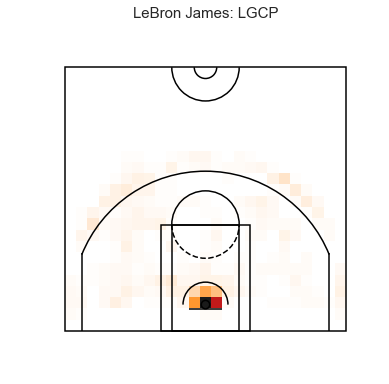

In [10]:
def plot_player_normLambda(player, norm_lambdaN_v, vmax=None):
    LAMBDA_v = np.reshape(norm_lambdaN_v, bins)
    ##########
    extent = np.min(xedges), np.max(xedges), np.max(yedges), np.min(yedges)
    
    plt.imshow(LAMBDA_v.T, cmap=plt.cm.gist_heat_r, alpha=.9, vmax=vmax,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.5)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s: LGCP'%(player), fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_player_normLambda(player, norm_lambdaN_v)

In [11]:
LL = np.zeros((num_players,np.prod(bins)))
for i, player in enumerate(top_players_nameList):
    try:
        norm_lambdaN_v = np.loadtxt('player_lambda/norm_lambda_%s.txt'%(player))
    except:
        Xn_v = player_shotHist_train[player]
        z0_guess = np.log(np.mean(Xn_v))
        zn_v_guess = np.zeros(len(Xn_v))
        z_guess = np.append(z0_guess, zn_v_guess)
    
        neg_logLike = lambda *args: -ln_postprob(*args)
        result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                         args=(Xn_v, det_cov_K, inv_cov_K))
        z_MaxLike = result["x"]
        z0_MaxLike = z_MaxLike[0]
        zn_MaxLike = z_MaxLike[1:]
        lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
        norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)
    
        np.savetxt('player_lambda/norm_lambda_%s.txt'%(player), norm_lambdaN_v)
    print(i, player)
    LL[i,:] = norm_lambdaN_v[:]

0 Kevin Durant
1 Carmelo Anthony
2 DeMar DeRozan
3 Kevin Love
4 LaMarcus Aldridge
5 Blake Griffin
6 Al Jefferson
7 Stephen Curry
8 LeBron James
9 Paul George
10 John Wall
11 Damian Lillard
12 Thaddeus Young
13 Dirk Nowitzki
14 Monta Ellis
15 Klay Thompson
16 Josh Smith
17 Kyrie Irving
18 James Harden
19 Zach Randolph
20 Jeff Green
21 DeMarcus Cousins
22 Rudy Gay
23 Bradley Beal
24 Brandon Jennings
25 Kemba Walker
26 Goran Dragic
27 Brandon Knight
28 Isaiah Thomas
29 Michael Carter-Williams
30 Kyle Lowry
31 Gordon Hayward
32 Paul Millsap
33 Mike Conley
34 Greg Monroe
35 Arron Afflalo
36 Kevin Martin
37 Wesley Matthews
38 Evan Turner
39 Jeff Teague
40 Anthony Davis
41 Jamal Crawford
42 Joe Johnson
43 Gerald Green
44 Chandler Parsons
45 Dion Waiters
46 Serge Ibaka
47 Carlos Boozer
48 J.R. Smith
49 Chris Bosh
50 David Lee
51 David West
52 Victor Oladipo
53 Reggie Jackson
54 Tony Parker
55 Gerald Henderson
56 Tim Duncan
57 Nick Young
58 Trey Burke
59 Jared Sullinger
60 Taj Gibson
61 Jodie M

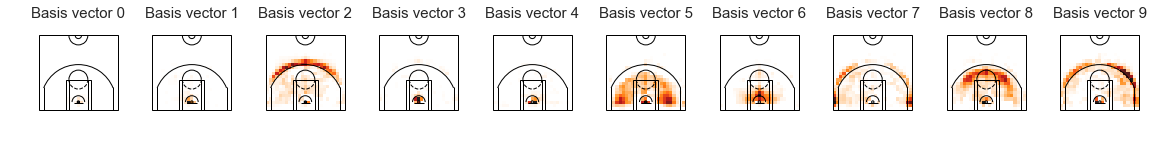

In [45]:
n_comp = 10
model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, solver='cd')
W = model.fit_transform(LL)
H = model.components_    


plt.figure(figsize=(20,14))
for i in range(n_comp):
    plt.subplot(1, n_comp, i+1)

    extent = np.max(xedges), np.min(xedges), np.max(yedges), np.min(yedges)

    plt.imshow(H[i,:].reshape(bins[0],bins[1]).T, cmap=plt.cm.gist_heat_r, alpha=.9,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.)

    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('Basis vector %d'%(i), fontsize=15)
    plt.axis('off')
plt.show()

In [46]:
[np.sum(H[i,:]) for i in range(n_comp)]

[1.6151116874300835,
 2.6064397435578246,
 4.7855172504630108,
 3.1322556917368036,
 2.4171597856833555,
 5.2871769498783117,
 5.1439995359704023,
 3.9689501891222454,
 4.0487770964580676,
 4.7256547206649913]

In [47]:
df_W = pd.DataFrame(W, index=top_players_nameList, columns = ['Basis %d'%i for i in range(n_comp)])
df_W[:3]

,Basis 0,Basis 1,Basis 2,Basis 3,Basis 4,Basis 5,Basis 6,Basis 7,Basis 8,Basis 9
Kevin Durant,0.066168,0.041479,0.083190,0.002457,0.009119,0.033610,0.016643,0.000457,0.022126,0.001285
Carmelo Anthony,0.036343,0.041088,0.037703,0.003066,0.008812,0.065434,0.000000,0.002634,0.030410,0.036916
DeMar DeRozan,0.026687,0.010794,0.000000,0.016258,0.020049,0.056613,0.011118,0.027076,0.068683,0.021594


In [48]:
W_norm = np.copy(W)
H_norm = np.copy(H)
for i in range(n_comp):
    temp = np.sum(H[i,:])
    W_norm[:,i] *= temp
    H_norm[i,:] *= 1./temp
[np.sum(W_norm[i,:]) for i in range(20)]

[1.0036169326096289,
 1.0311166116777377,
 1.0147268724348024,
 1.0605939469781922,
 1.0324284152030327,
 1.0197059770497245,
 1.0724416107067194,
 0.98316284523960218,
 1.0299265059658622,
 1.0159071876124288,
 1.0141227778675759,
 0.98996565892417587,
 1.0280079840533989,
 1.0304403446455535,
 0.97244739597392404,
 1.0004887718443098,
 0.97085266317745655,
 0.96485847258958579,
 1.0420333655137526,
 0.99160509739701852]

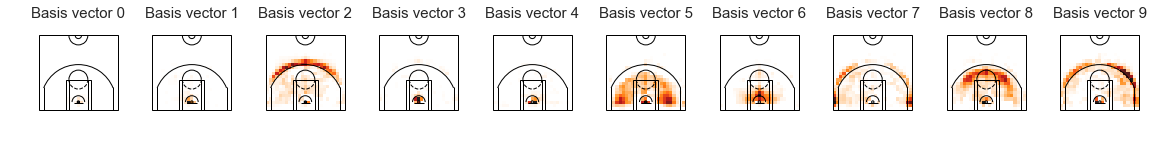

,Basis 0,Basis 1,Basis 2,Basis 3,Basis 4,Basis 5,Basis 6,Basis 7,Basis 8,Basis 9
Kevin Durant,0.106869,0.108112,0.398109,0.007695,0.022042,0.177702,0.085613,0.001815,0.089585,0.006074
Carmelo Anthony,0.058698,0.107093,0.180427,0.009603,0.021299,0.345961,0.000000,0.010455,0.123125,0.174454
DeMar DeRozan,0.043103,0.028133,0.000000,0.050925,0.048462,0.299322,0.057190,0.107463,0.278084,0.102045
Kevin Love,0.132657,0.081455,0.192970,0.032744,0.041659,0.056045,0.122934,0.000000,0.048739,0.351390
LaMarcus Aldridge,0.093607,0.000000,0.000000,0.014650,0.080230,0.284470,0.100294,0.000000,0.447062,0.012116
Blake Griffin,0.125398,0.147921,0.000000,0.221912,0.059797,0.033092,0.104866,0.000000,0.320950,0.005771
Al Jefferson,0.126539,0.035143,0.000000,0.029412,0.118101,0.311281,0.310869,0.000000,0.141097,0.000000
Stephen Curry,0.012885,0.013697,0.430658,0.080391,0.068914,0.000000,0.039996,0.106595,0.223897,0.006128
LeBron James,0.210728,0.189711,0.096129,0.062814,0.074579,0.133170,0.000000,0.023677,0.062475,0.176644
Paul George,0.071660,0.065653,0.234671,0.063359,0.036138,0.206010,0.000000,0.139012,0.098687,0.100718


In [49]:
plt.figure(figsize=(20,14))
for i in range(n_comp):
    plt.subplot(1, n_comp, i+1)

    extent = np.max(xedges), np.min(xedges), np.max(yedges), np.min(yedges)

    plt.imshow(H_norm[i,:].reshape(bins[0],bins[1]).T, cmap=plt.cm.gist_heat_r, alpha=.9,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.)

    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('Basis vector %d'%(i), fontsize=15)
    plt.axis('off')
plt.show()

df_W_norm = pd.DataFrame(W_norm, index=top_players_nameList, columns = ['Basis %d'%i for i in range(n_comp)])
df_W_norm[:20]

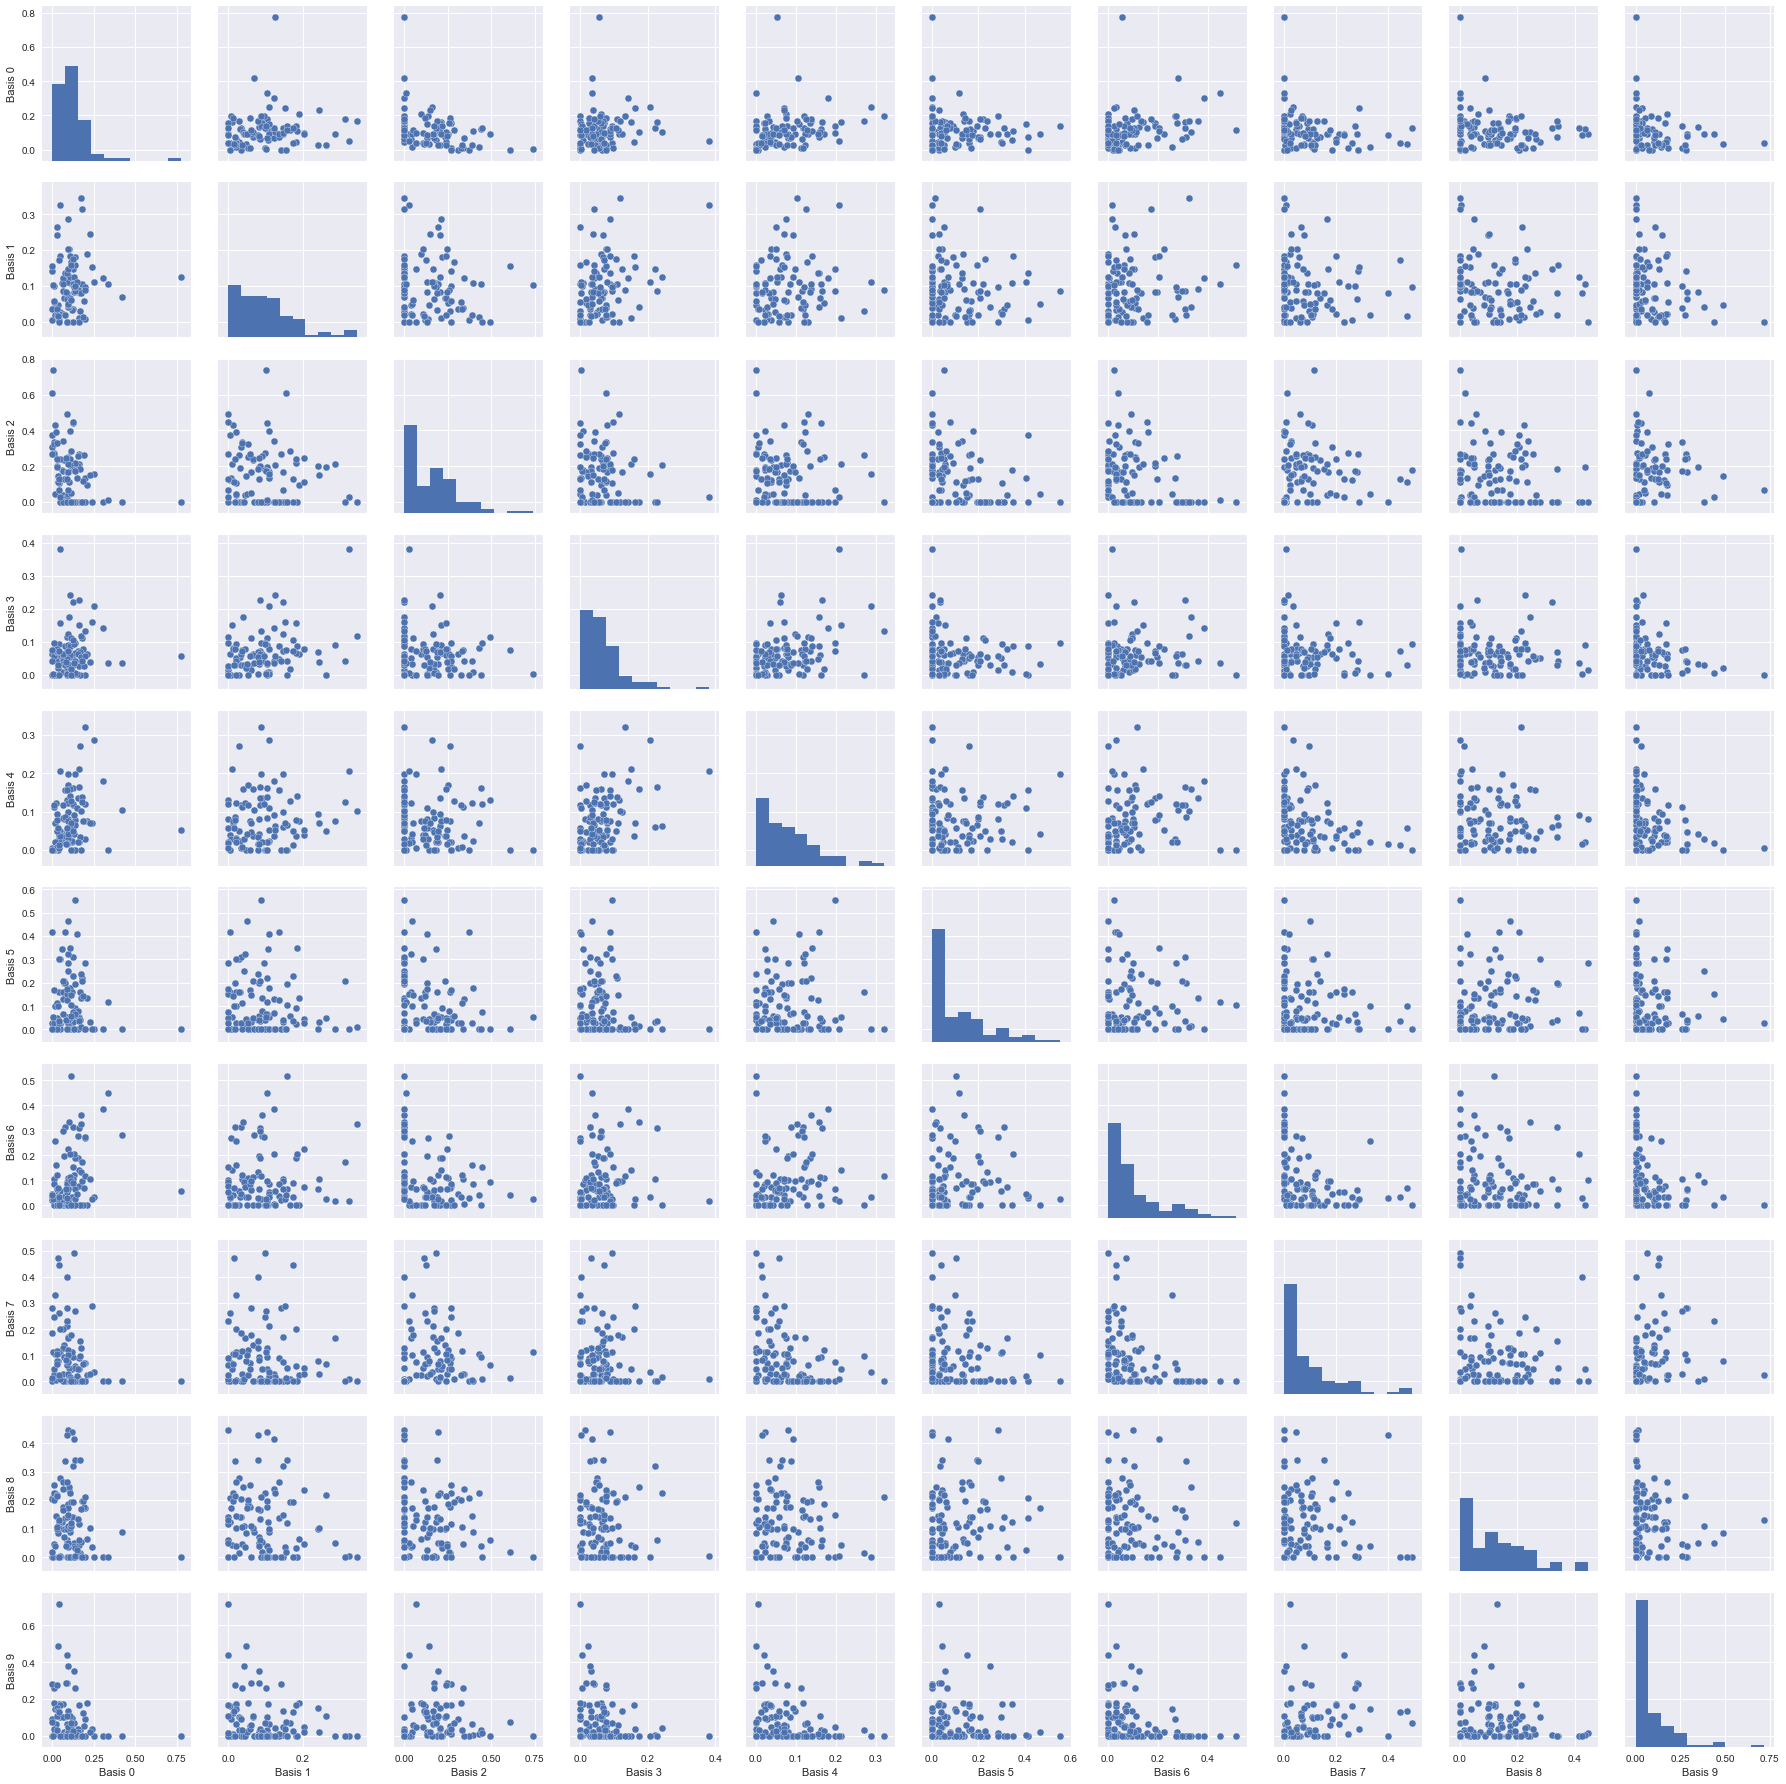

In [50]:
sns.pairplot(df_W_norm, vars=['Basis %d'%i for i in range(n_comp)])
plt.show()